In [ ]:
# Cell 1: Setup and Imports
from google.colab import drive
drive.mount('/content/drive')

!pip install pandas numpy pillow torch torchvision scikit-learn efficientnet_pytorch

import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score
import warnings
import time
from datetime import datetime
import zipfile

warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 2: Configuration and Paths
# Updated paths as requested
ZIP_PATH = '/content/drive/MyDrive/benign950_malignant50/Selected_JPEG_Aug.zip'
EXTRACT_DIR = '/content/Selected_JPEG_Aug/Selected_JPEG_Aug/Selected_JPEG_Aug/Selected_JPEG_Aug/Selected_JPEG_Aug'  # Temporary extraction location
CSV_PATH = '/content/drive/MyDrive/benign950_malignant50/selected_samples.csv'

# Training Configuration
BATCH_SIZE = 2
IMAGE_SIZE = 224
EPOCHS = 15  # Changed to 10 epochs for testing
VERBOSE = True
PRINT_FREQ = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create directory for saving models
MODEL_SAVE_DIR = '/content/drive/MyDrive/epoch_models'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

print(f"Using device: {DEVICE}")
print(f"CSV Path: {CSV_PATH}")
print(f"Model save directory: {MODEL_SAVE_DIR}")

Using device: cuda
CSV Path: /content/drive/MyDrive/benign950_malignant50/selected_samples.csv
Model save directory: /content/drive/MyDrive/epoch_models


In [ ]:
# Cell 3: Extract Dataset
# Step 1: Extract ZIP only if not extracted before
if not os.path.exists(EXTRACT_DIR):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
        print("Zip extracted successfully.")

# Step 2: Image Directory inside extracted folder
IMAGE_DIR = EXTRACT_DIR

# Check if CSV and images exist
assert os.path.exists(CSV_PATH), "CSV file not found!"
assert os.path.exists(IMAGE_DIR), "Image directory not found!"

# Count only image files with common image extensions
image_extensions = ('.jpg', '.jpeg', '.png')
file_count = len([name for name in os.listdir(IMAGE_DIR)
                  if name.lower().endswith(image_extensions) and os.path.isfile(os.path.join(IMAGE_DIR, name))])

print(f"Number of image files in directory '{IMAGE_DIR}': {file_count}")
print(f"Image Directory: {IMAGE_DIR}")

Number of image files in directory '/content/Selected_JPEG_Aug/Selected_JPEG_Aug/Selected_JPEG_Aug/Selected_JPEG_Aug/Selected_JPEG_Aug': 1000
Image Directory: /content/Selected_JPEG_Aug/Selected_JPEG_Aug/Selected_JPEG_Aug/Selected_JPEG_Aug/Selected_JPEG_Aug


In [ ]:
# Cell 4: Custom Dataset Class
class JPEGDataset(Dataset):
    def __init__(self, dataframe, root_dir=IMAGE_DIR, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx]["image_name"] + ".jpg")
        try:
            image = Image.open(img_name).convert("RGB")
            if self.transform:
                image = self.transform(image)
            label = self.dataframe.iloc[idx]["target"]
            return image, torch.tensor(label, dtype=torch.float32)
        except Exception as e:
            print(f"Error loading {img_name}: {str(e)}")
            dummy_img = torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE)
            return dummy_img, torch.tensor(0.0, dtype=torch.float32)

In [ ]:
# Cell 5: Data Preparation
def prepare_data_with_test(csv_path, image_dir, test_size=0.2, val_size=0.2):
    df = pd.read_csv(csv_path)
    existing = set(os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith(".jpg"))
    df = df[df["image_name"].isin(existing)]
    df = df[["image_name", "target"]].dropna()

    # Split into test (10%)
    train_val_df, test_df = train_test_split(
        df, test_size=test_size, random_state=42, stratify=df["target"]
    )

    # Split train_val into train/val (10% val of remaining)
    val_frac = val_size / (1 - test_size)
    train_df, val_df = train_test_split(
        train_val_df, test_size=val_frac, random_state=42, stratify=train_val_df["target"]
    )

    print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    print(f"Train distribution - Benign: {len(train_df[train_df['target']==0])}, Malignant: {len(train_df[train_df['target']==1])}")
    print(f"Val distribution - Benign: {len(val_df[val_df['target']==0])}, Malignant: {len(val_df[val_df['target']==1])}")
    print(f"Test distribution - Benign: {len(test_df[test_df['target']==0])}, Malignant: {len(test_df[test_df['target']==1])}")

    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_ds = JPEGDataset(train_df, root_dir=image_dir, transform=transform)
    val_ds   = JPEGDataset(val_df, root_dir=image_dir, transform=transform)
    test_ds  = JPEGDataset(test_df, root_dir=image_dir, transform=transform)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader, train_df, val_df, test_df

In [ ]:
# Cell 6: Model Setup
def setup_model():
    model = EfficientNet.from_pretrained("efficientnet-b0")
    model._fc = nn.Linear(model._fc.in_features, 1)
    model = model.to(DEVICE)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    return model, criterion, optimizer

In [ ]:
# Cell 7: Evaluation Function
def evaluate_model(model, loader, dataset_name=""):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy().flatten()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy().flatten())

    bin_preds = [1 if p >= 0.5 else 0 for p in all_preds]

    acc = accuracy_score(all_labels, bin_preds)
    auc = roc_auc_score(all_labels, all_preds) if len(set(all_labels)) > 1 else 0.0
    recall = recall_score(all_labels, bin_preds) if len(set(all_labels)) > 1 else 0.0

    print(f"{dataset_name} Results:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  AUC: {auc:.4f}")
    print(f"  Recall: {recall:.4f}")

    return acc, auc, recall

In [ ]:
# Cell 8: Main Training Loop with Epoch Testing
def train_and_evaluate_epochs(model, criterion, optimizer, train_loader, val_loader, test_loader):
    results_log = []

    print(f"Starting training for {EPOCHS} epochs...")
    overall_start_time = datetime.now()
    print(f"Training started at: {overall_start_time.strftime('%Y-%m-%d %H:%M:%S')}")

    for epoch in range(EPOCHS):
        # Log epoch start time
        epoch_start_time = datetime.now()
        print(f"\nEpoch {epoch+1}/{EPOCHS} started at: {epoch_start_time.strftime('%Y-%m-%d %H:%M:%S')}")

        # Training phase
        model.train()
        running_loss = 0.0
        total_samples = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.flatten(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            total_samples += images.size(0)

            if VERBOSE and (batch_idx % PRINT_FREQ == 0 or batch_idx == len(train_loader) - 1):
                print(f"  Batch {batch_idx+1}/{len(train_loader)} | Loss: {loss.item():.4f}")

        train_loss = running_loss / total_samples

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs.flatten(), labels)
                val_loss += loss.item() * images.size(0)
        val_loss /= len(val_loader.dataset)

        # Log epoch end time
        epoch_end_time = datetime.now()
        epoch_duration = epoch_end_time - epoch_start_time
        print(f"Epoch {epoch+1} ended at: {epoch_end_time.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Epoch {epoch+1} duration: {epoch_duration}")

        # Save model for this epoch
        model_save_path = os.path.join(MODEL_SAVE_DIR, f'augmented_ogsize_images_efficientnet_b0_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, model_save_path)

        print(f"Model saved at: {model_save_path}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Evaluate on all datasets
        print(f"\nEvaluating Epoch {epoch+1} model:")
        train_acc, train_auc, train_recall = evaluate_model(model, train_loader, "Train")
        val_acc, val_auc, val_recall = evaluate_model(model, val_loader, "Validation")
        test_acc, test_auc, test_recall = evaluate_model(model, test_loader, "Test")

        # Log results
        epoch_results = {
            'epoch': epoch + 1,
            'epoch_start_time': epoch_start_time.strftime('%Y-%m-%d %H:%M:%S'),
            'epoch_end_time': epoch_end_time.strftime('%Y-%m-%d %H:%M:%S'),
            'epoch_duration': str(epoch_duration),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'train_auc': train_auc,
            'train_recall': train_recall,
            'val_acc': val_acc,
            'val_auc': val_auc,
            'val_recall': val_recall,
            'test_acc': test_acc,
            'test_auc': test_auc,
            'test_recall': test_recall,
            'model_path': model_save_path
        }
        results_log.append(epoch_results)

        print("-" * 80)

    overall_end_time = datetime.now()
    total_duration = overall_end_time - overall_start_time
    print(f"\nTotal training completed at: {overall_end_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Total training duration: {total_duration}")

    return results_log

In [ ]:
# Cell 9: Execute Training and Data Preparation
# Prepare data
train_loader, val_loader, test_loader, train_df, val_df, test_df = prepare_data_with_test(CSV_PATH, IMAGE_DIR)

# Setup model
model, criterion, optimizer = setup_model()

# Train and evaluate across epochs
results_log = train_and_evaluate_epochs(model, criterion, optimizer, train_loader, val_loader, test_loader)

Train: 600, Val: 200, Test: 200
Train distribution - Benign: 570, Malignant: 30
Val distribution - Benign: 190, Malignant: 10
Test distribution - Benign: 190, Malignant: 10
Loaded pretrained weights for efficientnet-b0
Starting training for 15 epochs...
Training started at: 2025-06-22 14:13:01

Epoch 1/15 started at: 2025-06-22 14:13:01
  Batch 1/300 | Loss: 0.7690
  Batch 51/300 | Loss: 0.3441
  Batch 101/300 | Loss: 0.2020
  Batch 151/300 | Loss: 0.0781
  Batch 201/300 | Loss: 0.0559
  Batch 251/300 | Loss: 0.0556
  Batch 300/300 | Loss: 0.0485
Epoch 1 ended at: 2025-06-22 14:15:39
Epoch 1 duration: 0:02:38.537869
Model saved at: /content/drive/MyDrive/epoch_models/augmented_ogsize_images_efficientnet_b0_epoch_1.pth
Train Loss: 0.2835 | Val Loss: 0.2242

Evaluating Epoch 1 model:
Train Results:
  Accuracy: 0.9317
  AUC: 0.7153
  Recall: 0.0333
Validation Results:
  Accuracy: 0.9500
  AUC: 0.6579
  Recall: 0.2000
Test Results:
  Accuracy: 0.9300
  AUC: 0.8163
  Recall: 0.0000
--------

Results saved to: /content/drive/MyDrive/epoch_models/epoch_comparison_results.csv

Epoch Comparison Summary:
Epoch  Train Loss   Val Loss   Test Acc   Test AUC   Test Recall  Duration    
----------------------------------------------------------------------------------------------------
1      0.2835       0.2242     0.9300     0.8163     0.0000       0:02:38.537869
2      0.1897       0.2506     0.9500     0.7658     0.1000       0:02:38.704444
3      0.1758       0.2322     0.9500     0.7805     0.0000       0:02:38.624650
4      0.1357       0.2692     0.8950     0.7705     0.2000       0:02:38.044792
5      0.1150       0.2747     0.9450     0.7000     0.1000       0:02:37.671038
6      0.0921       0.4260     0.7650     0.7595     0.5000       0:02:38.312976
7      0.0677       0.3379     0.8700     0.7626     0.4000       0:02:37.367994
8      0.0381       0.3817     0.8350     0.7358     0.5000       0:02:38.255026
9      0.0216       0.4270     0.8350     0.7211     0.6000   

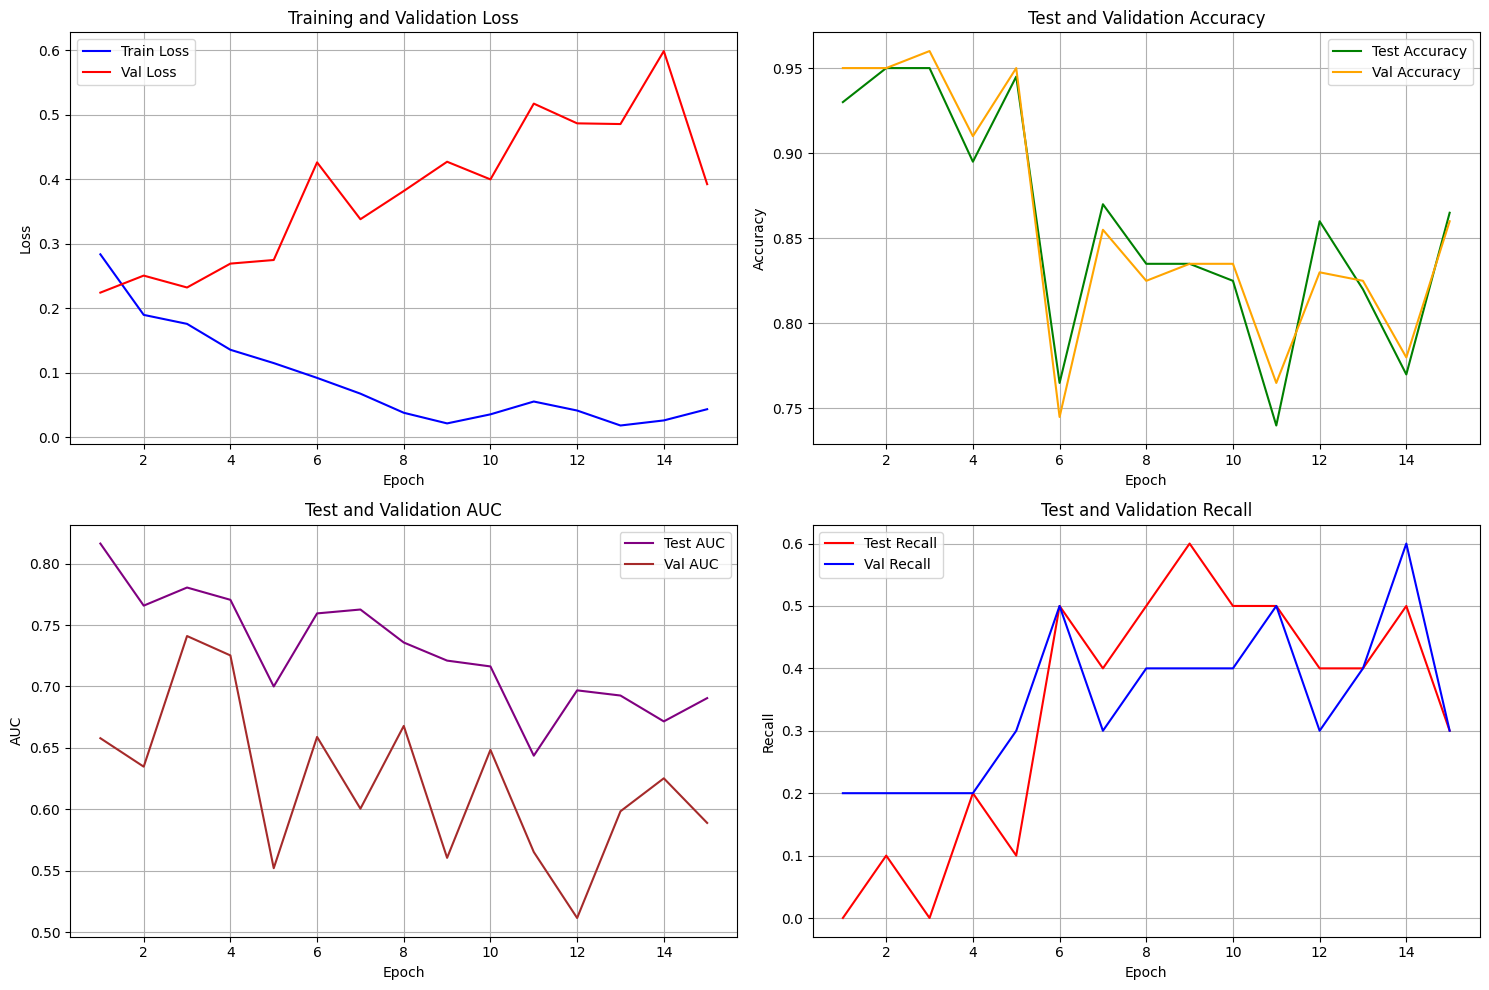


All models saved in: /content/drive/MyDrive/epoch_models
Training complete!


In [ ]:
# Cell 10: Results Analysis and Summary
# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results_log)

# Save results to CSV
results_csv_path = os.path.join(MODEL_SAVE_DIR, 'epoch_comparison_results.csv')
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to: {results_csv_path}")

# Display summary
print("\nEpoch Comparison Summary:")
print("=" * 100)
print(f"{'Epoch':<6} {'Train Loss':<12} {'Val Loss':<10} {'Test Acc':<10} {'Test AUC':<10} {'Test Recall':<12} {'Duration':<12}")
print("-" * 100)

for _, row in results_df.iterrows():
    print(f"{row['epoch']:<6} {row['train_loss']:<12.4f} {row['val_loss']:<10.4f} "
          f"{row['test_acc']:<10.4f} {row['test_auc']:<10.4f} {row['test_recall']:<12.4f} {row['epoch_duration']:<12}")

# Find best epoch based on test accuracy
best_epoch_idx = results_df['test_acc'].idxmax()
best_epoch = results_df.loc[best_epoch_idx]

print(f"\nBest performing epoch: {best_epoch['epoch']}")
print(f"Best test accuracy: {best_epoch['test_acc']:.4f}")
print(f"Best test AUC: {best_epoch['test_auc']:.4f}")
print(f"Best test recall: {best_epoch['test_recall']:.4f}")
print(f"Best model path: {best_epoch['model_path']}")

# Plot training curves if matplotlib is available
try:
    import matplotlib.pyplot as plt

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    epochs = results_df['epoch']

    # Loss curves
    ax1.plot(epochs, results_df['train_loss'], 'b-', label='Train Loss')
    ax1.plot(epochs, results_df['val_loss'], 'r-', label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy curves
    ax2.plot(epochs, results_df['test_acc'], 'g-', label='Test Accuracy')
    ax2.plot(epochs, results_df['val_acc'], 'orange', label='Val Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Test and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    # AUC curves
    ax3.plot(epochs, results_df['test_auc'], 'purple', label='Test AUC')
    ax3.plot(epochs, results_df['val_auc'], 'brown', label='Val AUC')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('AUC')
    ax3.set_title('Test and Validation AUC')
    ax3.legend()
    ax3.grid(True)

    # Recall curves
    ax4.plot(epochs, results_df['test_recall'], 'red', label='Test Recall')
    ax4.plot(epochs, results_df['val_recall'], 'blue', label='Val Recall')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Recall')
    ax4.set_title('Test and Validation Recall')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_SAVE_DIR, 'training_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()

except ImportError:
    print("Matplotlib not available. Skipping plots.")

print(f"\nAll models saved in: {MODEL_SAVE_DIR}")
print("Training complete!")

In [ ]:
# Cell 11: Load and Test Best Model (Optional)
# Load the best performing model for further testing
def load_and_test_best_model():
    # Find best model path from results
    best_epoch_idx = results_df['test_acc'].idxmax()
    best_model_path = results_df.loc[best_epoch_idx, 'model_path']
    best_epoch_num = results_df.loc[best_epoch_idx, 'epoch']

    print(f"Loading best model from epoch {best_epoch_num}")
    print(f"Model path: {best_model_path}")

    # Setup fresh model architecture
    model, criterion, optimizer = setup_model()

    # Load the saved checkpoint
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print(f"Successfully loaded model from epoch {checkpoint['epoch']}")

    # Final evaluation on test set
    print("\nFinal evaluation with best model:")
    test_acc, test_auc, test_recall = evaluate_model(model, test_loader, "Final Test")

    return model, best_epoch_num, test_acc, test_auc, test_recall

# Uncomment the line below to load and test the best model
best_model, best_epoch_num, final_acc, final_auc, final_recall = load_and_test_best_model()

Loading best model from epoch 2
Model path: /content/drive/MyDrive/epoch_models/augmented_ogsize_images_efficientnet_b0_epoch_2.pth
Loaded pretrained weights for efficientnet-b0
Successfully loaded model from epoch 2

Final evaluation with best model:
Final Test Results:
  Accuracy: 0.9500
  AUC: 0.7658
  Recall: 0.1000


In [ ]:
# Cell 10: Results Analysis and Summary
# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results_log)

# Save results to CSV
results_csv_path = os.path.join(MODEL_SAVE_DIR, 'epoch_comparison_results.csv')
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to: {results_csv_path}")

# Display summary
print("\nEpoch Comparison Summary:")
print("=" * 100)
print(f"{'Epoch':<6} {'Train Loss':<12} {'Val Loss':<10} {'Test Acc':<10} {'Test AUC':<10} {'Test Recall':<12} {'Duration':<12}")
print("-" * 100)

for _, row in results_df.iterrows():
    print(f"{row['epoch']:<6} {row['train_loss']:<12.4f} {row['val_loss']:<10.4f} "
          f"{row['test_acc']:<10.4f} {row['test_auc']:<10.4f} {row['test_recall']:<12.4f} {row['epoch_duration']:<12}")

# Find best epoch based on test accuracy
best_epoch_idx = results_df['test_acc'].idxmax()
best_epoch = results_df.loc[best_epoch_idx]

print(f"\nBest performing epoch: {best_epoch['epoch']}")
print(f"Best test accuracy: {best_epoch['test_acc']:.4f}")
print(f"Best test AUC: {best_epoch['test_auc']:.4f}")
print(f"Best test recall: {best_epoch['test_recall']:.4f}")
print(f"Best model path: {best_epoch['model_path']}")

# Plot training curves if matplotlib is available
try:
    import matplotlib.pyplot as plt

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    epochs = results_df['epoch']

    # Loss curves
    ax1.plot(epochs, results_df['train_loss'], 'b-', label='Train Loss')
    ax1.plot(epochs, results_df['val_loss'], 'r-', label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy curves
    ax2.plot(epochs, results_df['test_acc'], 'g-', label='Test Accuracy')
    ax2.plot(epochs, results_df['val_acc'], 'orange', label='Val Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Test and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    # AUC curves
    ax3.plot(epochs, results_df['test_auc'], 'purple', label='Test AUC')
    ax3.plot(epochs, results_df['val_auc'], 'brown', label='Val AUC')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('AUC')
    ax3.set_title('Test and Validation AUC')
    ax3.legend()
    ax3.grid(True)

    # Recall curves
    ax4.plot(epochs, results_df['test_recall'], 'red', label='Test Recall')
    ax4.plot(epochs, results_df['val_recall'], 'blue', label='Val Recall')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Recall')
    ax4.set_title('Test and Validation Recall')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_SAVE_DIR, 'training_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()

except ImportError:
    print("Matplotlib not available. Skipping plots.")

print(f"\nAll models saved in: {MODEL_SAVE_DIR}")
print("Training complete!")

In [ ]:
# Cell 11: Load and Test Best Model (Optional)
# Load the best performing model for further testing
def load_and_test_best_model():
    # Find best model path from results
    best_epoch_idx = results_df['test_acc'].idxmax()
    best_model_path = results_df.loc[best_epoch_idx, 'model_path']
    best_epoch_num = results_df.loc[best_epoch_idx, 'epoch']

    print(f"Loading best model from epoch {best_epoch_num}")
    print(f"Model path: {best_model_path}")

    # Setup fresh model architecture
    model, criterion, optimizer = setup_model()

    # Load the saved checkpoint
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print(f"Successfully loaded model from epoch {checkpoint['epoch']}")

    # Final evaluation on test set
    print("\nFinal evaluation with best model:")
    test_acc, test_auc, test_recall = evaluate_model(model, test_loader, "Final Test")

    return model, best_epoch_num, test_acc, test_auc, test_recall

# Uncomment the line below to load and test the best model
best_model, best_epoch_num, final_acc, final_auc, final_recall = load_and_test_best_model()